Import library

In [1]:
import os
import numpy as np
import random
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms
from torchvision.utils import save_image


초기 파라미터 설정

In [2]:
image_path = './images'
channels = 1                    # MNIST has only 1-흑백사진

n_epochs = 10                   #학습 횟수
batch_size = 128                #한번에 학습할 이미지 갯수
lr = 1e-3                       #Learning rate
b1 = 0.5
b2 = 0.999

img_size = 28
hidden_dim = 400
latent_dim = 10

In [3]:
os.makedirs(image_path, exist_ok=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


mnist train, test dataset 불러오기

In [5]:
transform = transforms.Compose([
            transforms.ToTensor()
            ])

train = datasets.MNIST(root='./data/',train=True,transform=transform,download=True)
test = datasets.MNIST(root='./data/',train=False,transform=transform,download=True)

train_dataloader = torch.utils.data.DataLoader(
            train,
            batch_size=batch_size,
            shuffle=True,

)

test_dataloader = torch.utils.data.DataLoader(
            test,
            batch_size=batch_size,
            shuffle=False,
)

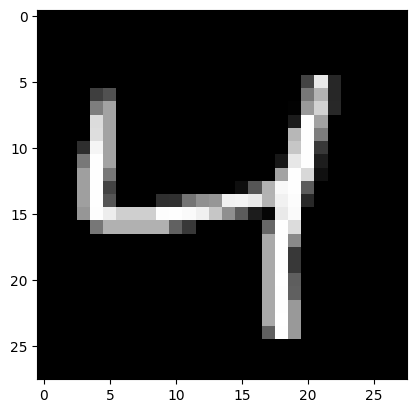

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train[2][0][0],cmap='gray')

Encoder 정의

In [7]:
class Encoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Encoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = self.fc2(self.fc1(x))

        mu = F.relu(self.mu(x))
        logvar = F.relu(self.logvar(x))

        z = reparameterization(mu, logvar)
        return z, mu, logvar

Decoder 정의

In [8]:
class Decoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Decoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.fc3 = nn.Linear(h_dim, x_dim)

    def forward(self, z):
        z = self.fc2(self.fc1(z))
        x_reconst = F.sigmoid(self.fc3(z))
        return x_reconst

reparameterization 함수 정의

In [9]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

In [10]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(b1, b2)
)

In [11]:
print(encoder)

Encoder(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (mu): Linear(in_features=400, out_features=10, bias=True)
  (logvar): Linear(in_features=400, out_features=10, bias=True)
)


In [12]:
print(decoder)

Decoder(
  (fc1): Sequential(
    (0): Linear(in_features=10, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Linear(in_features=400, out_features=784, bias=True)
)


In [ ]:

for epoch in range(n_epochs):
    #Train
    train_loss = 0
    for i, (x, _) in enumerate(train_dataloader):
        # forward
        x = x.view(-1, img_size**2)
        x = x.to(device)
        z, mu, logvar = encoder(x)
        x_reconst = decoder(z)

        # compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        # backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_dataloader)}], Reconst Loss : {reconst_loss.item():.4f}, KL Div: {kl_div.item():.4f}')

    print(f'===> Epoch: {epoch+1} Average Train Loss: {train_loss/len(train_dataloader.dataset):.4f} ')
    #Test
    test_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_dataloader):
            # forward
            x = x.view(-1, img_size**2)
            x = x.to(device)
            z, mu, logvar = encoder(x)
            x_reconst = decoder(z)

            # compute reconstruction loss and KL divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

            loss = reconst_loss + kl_div
            test_loss += loss.item()

            # save reconstruction images
            if i==0:
                x_concat = torch.cat([x.view(-1, 1, 28, 28), x_reconst.view(-1, 1, 28, 28)], dim=3)
                # batch size 개수만큼의 이미지 쌍(input x, reconstructed x)이 저장됨
                save_image(x_concat, os.path.join(image_path,f'reconst-epoch{epoch+1}.png'))

        print(f'===> Epoch: {epoch+1} Average Test Loss: {test_loss/len(test_dataloader.dataset):.4f} ')

        # save sampled images
        z = torch.randn(batch_size, latent_dim).to(device) # N(0, 1)에서 z 샘플링
        sampled_images = decoder(z)
        save_image(sampled_images.view(-1, 1, 28, 28), os.path.join(image_path,f'sampled-epoch{epoch+1}.png'))
